# 치와와, 머핀 분류

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from PIL import Image
import random

import torch
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder
import timm

from imgaug import augmenters as iaa
import imgaug as ia

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# CustomDataset

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, classes, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i, cls in enumerate(classes):
            cls_path = os.path.join(root_path, cls)
            img_list = os.listdir(cls_path)
            for img in img_list:
                if img != '.DS_Store':
                    self.data.append((os.path.join(cls_path, img), i))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        label = self.data[idx][1]

        return img, label

In [4]:
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
classes = ['chihuahua', 'muffin']

train_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/6/data/train', classes, transforms=transforms)
valid_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/6/data/val', classes, transforms=transforms)
test_dataset = CustomDataset('/Users/kimhongseok/cv_79_projects/part1/chapter1/6/data/test', classes, transforms=transforms)

In [5]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

4803
1176
36


In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=6, shuffle=False)

# training, evaluation

In [7]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        prob = torch.nn.functional.softmax(outputs, dim=1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, preds = torch.max(prob, 1)
        train_accuracy += (preds == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_accuracy /= len(train_dataset)

    return model, train_loss, train_accuracy

def evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            probs = torch.nn.functional.softmax(outputs, dim=1)

            valid_loss += loss.item()
            max_prob, preds = torch.max(probs, 1)
            valid_accuracy += (preds == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}] Train Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_accuracy /= len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    model.to(device)
    train_loss_list = []
    train_accuracy_list = []
    valid_loss_list = []
    valid_accuracy_list = []

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Valid Loss: {valid_loss}, Valid Accuracy: {valid_accuracy}')

    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy)
    valid_loss_list.append(valid_loss)
    valid_accuracy_list.append(valid_accuracy)

    return model, train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list

# model

In [8]:
model = timm.create_model(
    'resnet34',
    num_classes=2,
    pretrained=True
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [9]:
# 모든 파라미터의 requires_grad를 False로 설정
for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

In [10]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model, train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 10)

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Train Loss: 0.3684738784244186, Train Accuracy: 0.9248386425150947, Valid Loss: 0.2023536285033097, Valid Accuracy: 0.9770408163265306


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Train Loss: 0.16131496743152016, Train Accuracy: 0.976889444097439, Valid Loss: 0.12540098199167768, Valid Accuracy: 0.9787414965986394


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Train Loss: 0.11221114129416253, Train Accuracy: 0.981261711430356, Valid Loss: 0.09709270056840535, Valid Accuracy: 0.9812925170068028


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Train Loss: 0.08904574517356723, Train Accuracy: 0.9800124921923797, Valid Loss: 0.08249258622527122, Valid Accuracy: 0.9812925170068028


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Train Loss: 0.07680701856550418, Train Accuracy: 0.983968353112638, Valid Loss: 0.0685104423680821, Valid Accuracy: 0.9863945578231292


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Train Loss: 0.07125223104498889, Train Accuracy: 0.9818863210493441, Valid Loss: 0.06458417920244706, Valid Accuracy: 0.983843537414966


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Train Loss: 0.05963204676089318, Train Accuracy: 0.987299604413908, Valid Loss: 0.056418934333566075, Valid Accuracy: 0.9872448979591837


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Train Loss: 0.0596591753787116, Train Accuracy: 0.9862585883822611, Valid Loss: 0.05368928978773388, Valid Accuracy: 0.9863945578231292


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Train Loss: 0.05153749826805372, Train Accuracy: 0.9877160108265667, Valid Loss: 0.05164081839894926, Valid Accuracy: 0.9863945578231292


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

Train Loss: 0.050708722911382974, Train Accuracy: 0.9854257755569436, Valid Loss: 0.04897367959288326, Valid Accuracy: 0.9855442176870748


# test

In [11]:
model.eval()
total_preds = []
test_accuracy = 0

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)

        max_prob, preds = torch.max(probs, 1)
        test_accuracy += (preds==labels).sum()

        total_preds.extend(preds)

print((test_accuracy/len(test_dataset)).cpu().item())

  0%|          | 0/6 [00:00<?, ?it/s]

1.0


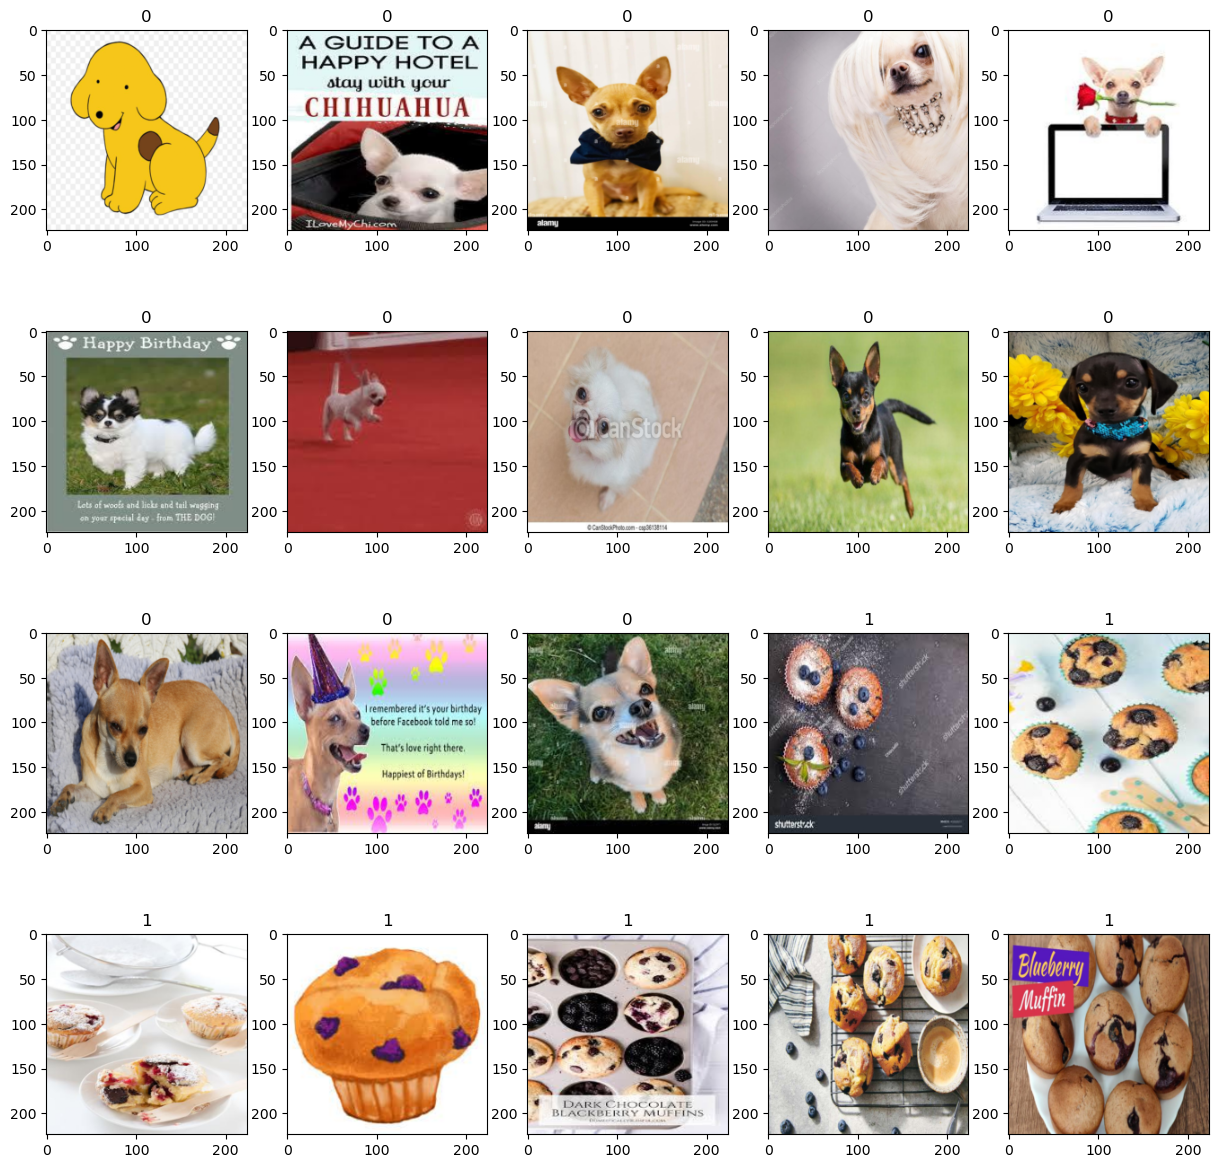

In [19]:
plt.figure(figsize=(15, 15))

for i in range(5, 25):
    ax = plt.subplot(4, 5, i-5+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(total_preds[i].cpu().item())